# Using a single Table vs EArray + Table

The PyTables community keep asking what can be considered a FAQ.  Namely, should I use a single Table for storing my data, or should I split it in a Table and an Array?

Although there is not a totally general answer, the study below address this for the common case where one has 'raw data' and other data that can be considered 'meta'.  See for example: https://groups.google.com/forum/#!topic/pytables-users/vBEiaRzp3gI

In [156]:
import numpy as np
import tables
tables.print_versions()

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PyTables version:    3.2.4.dev0
HDF5 version:        1.8.16
NumPy version:       1.11.0
Numexpr version:     2.4.3 (not using Intel's VML/MKL)
Zlib version:        1.2.8 (in Python interpreter)
Blosc version:       1.9.2 (2016-06-08)
Blosc compressors:   blosclz (1.0.5), lz4 (1.7.2), lz4hc (1.7.2), snappy (1.1.1), zlib (1.2.8)
Blosc filters:       shuffle, bitshuffle
Cython version:      0.23.4
Python version:      2.7.12 (default, Jul  1 2016, 15:12:24) 
[GCC 5.4.0 20160609]
Platform:            Linux-4.6.4-gentoo-x86_64-with-Ubuntu-16.04-xenial
Byte-ordering:       little
Detected cores:      8
Default encoding:    ascii
Default FS encoding: UTF-8
Default locale:      (en_US, UTF-8)
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [157]:
LEN_PMT = int(1.2e6)
NPMTS = 12
NEVENTS = 10

In [158]:
!rm PMT*.h5

In [159]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x = np.linspace(0, 1, 1e7)
rd = (gaussian(x, 1, 1.) * 1e6).astype(np.int32)

def raw_data(length):
    # Return the actual data that you think it represents PM waveforms better 
    #return np.arange(length, dtype=np.int32)
    return rd[:length]

## Using Tables to store everything

In [160]:
class PMTRD(tables.IsDescription):
    # event_id = tables.Int32Col(pos=1, indexed=True) 
    event_id = tables.Int32Col(pos=1)
    npmt = tables.Int8Col(pos=2)
    pmtrd = tables.Int32Col(shape=LEN_PMT, pos=3) 

In [161]:
def one_table(filename, filters):
    with tables.open_file("{}-{}-{}.h5".format(filename, filters.complib, filters.complevel), "w", filters=filters) as h5t:
        pmt = h5t.create_table(h5t.root, "pmt", PMTRD, expectedrows=NEVENTS*NPMTS)
        pmtr = pmt.row
        for i in range(NEVENTS):
            for j in range(NPMTS):
                pmtr['event_id'] = i
                pmtr['npmt'] = j
                pmtr['pmtrd'] = raw_data(LEN_PMT)
                pmtr.append()

In [162]:
# Using no compression
%time one_table("PMTs", tables.Filters(complib="zlib", complevel=0))

CPU times: user 220 ms, sys: 104 ms, total: 324 ms
Wall time: 323 ms


In [163]:
# Using Zlib (level 5) compression
%time one_table("PMTs", tables.Filters(complib="zlib", complevel=5))

CPU times: user 3.16 s, sys: 16 ms, total: 3.17 s
Wall time: 3.17 s


In [164]:
# Using Blosc (level 9) compression
%time one_table("PMTs", tables.Filters(complib="blosc:lz4", complevel=9))

CPU times: user 596 ms, sys: 4 ms, total: 600 ms
Wall time: 599 ms


In [165]:
ls -sh *.h5

 42M PMTs-blosc:lz4-9.h5  550M PMTs-None-0.h5   17M PMTs-zlib-5.h5


So, using no compression leads to best speed, whereas Zlib can compress data by ~32x.  Zlib is ~3x slower than using no compression though.  On its hand, the Blosc compressor is faster but it can barely compress the dataset.

## Using EArrays for storing raw data and Table for other metadata

In [166]:
def rawdata_earray(filename, filters):
    with tables.open_file("{}-{}.h5".format(filename, filters.complib), "w", filters=filters) as h5a:
        pmtrd = h5a.create_earray(h5a.root, "pmtrd", tables.Int32Atom(), shape=(0, NPMTS, LEN_PMT),
                                  chunkshape=(1,1,LEN_PMT))
        for i in range(NEVENTS):
            rdata = []
            for j in range(NPMTS):
                rdata.append(raw_data(LEN_PMT))
            pmtrd.append(np.array(rdata).reshape(1, NPMTS, LEN_PMT))
        pmtrd.flush()

In [167]:
# Using no compression
%time rawdata_earray("PMTAs", tables.Filters(complib="zlib", complevel=0))

CPU times: user 120 ms, sys: 132 ms, total: 252 ms
Wall time: 250 ms


In [168]:
# Using Zlib (level 5) compression
%time rawdata_earray("PMTAs", tables.Filters(complib="zlib", complevel=5))

CPU times: user 2.72 s, sys: 24 ms, total: 2.74 s
Wall time: 2.74 s


In [169]:
# Using Blosc (level 5) compression
%time rawdata_earray("PMTAs", tables.Filters(complib="blosc:lz4", complevel=9))

CPU times: user 224 ms, sys: 36 ms, total: 260 ms
Wall time: 258 ms


In [170]:
!ls -sh *.h5

9.0M PMTAs-blosc:lz4.h5  4.1M PMTAs-zlib.h5	   550M PMTs-None-0.h5
550M PMTAs-None.h5	  42M PMTs-blosc:lz4-9.h5   17M PMTs-zlib-5.h5


We see that by using the Blosc compressor one can achieve around 10x faster output operation wrt Zlib, although the compression ratio can be somewhat smaller (but still pretty good).

In [171]:
# Add the event IDs in a separate table in the same file
class PMTRD(tables.IsDescription):
    # event_id = tables.Int32Col(pos=1, indexed=True) 
    event_id = tables.Int32Col(pos=1)
    npmt = tables.Int8Col(pos=2)

def add_table(filename, filters):
    with tables.open_file("{}-{}.h5".format(filename, filters.complib), "a", filters=filters) as h5a:
        pmt = h5a.create_table(h5a.root, "pmt", PMTRD)
        pmtr = pmt.row
        for i in range(NEVENTS):
            for j in range(NPMTS):
                pmtr['event_id'] = i
                pmtr['npmt'] = j
                pmtr.append()

In [172]:
# Using no compression
%time add_table("PMTAs", tables.Filters(complib="zlib", complevel=0))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.79 ms


In [173]:
# Using Zlib (level 5) compression
%time add_table("PMTAs", tables.Filters(complib="zlib", complevel=5))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.74 ms


In [174]:
# Using Blosc (level 9) compression
%time add_table("PMTAs", tables.Filters(complib="blosc:lz4", complevel=9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.52 ms


In [175]:
!ls -sh *.h5

9.0M PMTAs-blosc:lz4.h5  4.1M PMTAs-zlib.h5	   550M PMTs-None-0.h5
550M PMTAs-None.h5	  42M PMTs-blosc:lz4-9.h5   17M PMTs-zlib-5.h5


After adding the table we continue to see that a better compression ratio is achieved for EArray + Table with respect to a single Table.  Also, Blosc can make writing files significantly faster than not using compression (it has to write less).

## Retrieving data from a single Table

In [187]:
def read_single_table(complib, complevel):
    with tables.open_file("PMTs-{}-{}.h5".format(complib, complevel), "r") as h5t:
        pmt = h5t.root.pmt
        for i, row in enumerate(pmt):
            event_id, npmt, pmtrd = row["event_id"], row["npmt"], row["pmtrd"][:]
            if i % 20 == 0:
                print(event_id, npmt, pmtrd[0:5])

In [177]:
%time read_single_table("None", 0)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 24 ms, sys: 80 ms, total: 104 ms
Wall time: 99 ms


In [178]:
%time read_single_table("zlib", 5)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 576 ms, sys: 24 ms, total: 600 ms
Wall time: 593 ms


In [179]:
%time read_single_table("blosc:lz4", 9)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 776 ms, sys: 16 ms, total: 792 ms
Wall time: 782 ms


As Blosc could not compress the table, it has a performance that is worse (quite worse actually) to the uncompressed table.  On its hand, Zlib can be more than 3x slower for reading than without compression.

## Retrieving data from the EArray + Table

In [180]:
def read_earray_table(complib, complevel):
    with tables.open_file("PMTAs-{}.h5".format(complib, "r")) as h5a:
        pmt = h5a.root.pmt
        pmtrd_ = h5a.root.pmtrd
        for i, row in enumerate(pmt):
            event_id, npmt = row["event_id"], row["npmt"]
            pmtrd = pmtrd_[event_id, npmt]
            if i % 20 == 0:
                print(event_id, npmt, pmtrd[0:5])

In [181]:
%time read_earray_table("None", 0)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 4 ms, sys: 80 ms, total: 84 ms
Wall time: 82 ms


In [182]:
%time read_earray_table("zlib", 5)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 992 ms, sys: 104 ms, total: 1.1 s
Wall time: 1.09 s


In [183]:
%time read_earray_table("blosc:lz4", 9)

(0, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(1, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(3, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(5, 0, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(6, 8, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
(8, 4, array([606530, 606530, 606530, 606530, 606530], dtype=int32))
CPU times: user 168 ms, sys: 4 ms, total: 172 ms
Wall time: 171 ms


So, the EArray + Table takes a similar time to read than a pure Table approach when no compression is used. And for some reason, when Zlib is used for compressing the data, the EArray + Table scenario degrades read speed significantly.  However, when the Blosc compression is used, the EArray + Table works actually faster than for the single Table. 

## Some plots on speeds and sizes

In [184]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Let's have a look at the speeds at which data can be stored and read using the different paradigms:

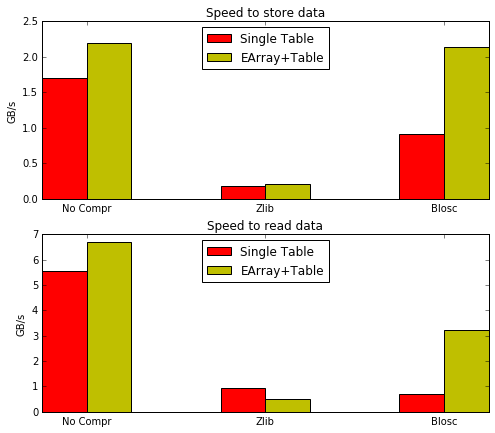

In [188]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=False, sharey=False)
fig.set_size_inches(w=8, h=7, forward=False)
f = .550   # conversion factor to GB/s
rects1 = ax1.bar(np.arange(3), f / np.array([.323, 3.17, .599]), 0.25, color='r')
rects2 = ax1.bar(np.arange(3) + 0.25, f / np.array([.250, 2.74, .258]), 0.25, color='y')
_ = ax1.set_ylabel('GB/s')
_ = ax1.set_xticks(np.arange(3) + 0.25)
_ = ax1.set_xticklabels(('No Compr', 'Zlib', 'Blosc'))
_ = ax1.legend((rects1[0], rects2[0]), ('Single Table', 'EArray+Table'), loc=9)
_ = ax1.set_title('Speed to store data')

rects1 = ax2.bar(np.arange(3), f / np.array([.099, .592, .782]), 0.25, color='r')
rects2 = ax2.bar(np.arange(3) + 0.25, f / np.array([.082, 1.09, .171]), 0.25, color='y')
_ = ax2.set_ylabel('GB/s')
_ = ax2.set_xticks(np.arange(3) + 0.25)
_ = ax2.set_xticklabels(('No Compr', 'Zlib', 'Blosc'))
_ = ax2.legend((rects1[0], rects2[0]), ('Single Table', 'EArray+Table'), loc=9)
_ = ax2.set_title('Speed to read data')

And now, see the different sizes for the final files:

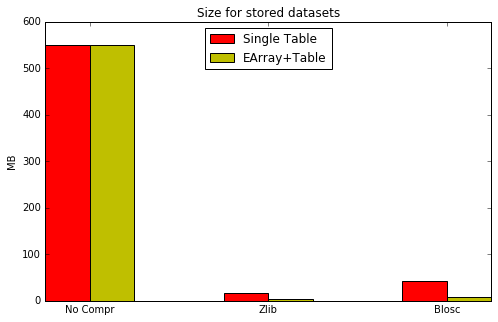

In [190]:
fig, ax1 = plt.subplots()
fig.set_size_inches(w=8, h=5)
rects1 = ax1.bar(np.arange(3), np.array([550, 17, 42]), 0.25, color='r')
rects2 = ax1.bar(np.arange(3) + 0.25, np.array([550, 4.1, 9]), 0.25, color='y')
_ = ax1.set_ylabel('MB')
_ = ax1.set_xticks(np.arange(3) + 0.25)
_ = ax1.set_xticklabels(('No Compr', 'Zlib', 'Blosc'))
_ = ax1.legend((rects1[0], rects2[0]), ('Single Table', 'EArray+Table'), loc=9)
_ = ax1.set_title('Size for stored datasets')

## Conclusions

The main conclusion here is that, whenever you have a lot of data to dump (typically in the form of an array), a combination of an EArray + Table is preferred instead of a single Table.  The reason for this is that HDF5 can store the former arrangement more efficiently, and that fast compressors like Blosc works way better too.

The deep explanation on why using an EArray to store the raw data gives these advanatges is because we are physically (not only logically!) separating data that is highly related (like the result of some measurements) and also is homogeneous (of type Int32 in this case).  This manual separation is critical for getting better compression ratios and faster speeds too, specially when using fast compressors like Blosc.

Finally, although meaningful, this experiment is based on a pure synthetic dataset.  It is always wise to use your own data in order to get your conclusions.  It is specially recommended to have a look at the different compressors that comes with PyTables and see which one fits better to your needs: http://www.pytables.org/usersguide/libref/helper_classes.html